# Modeling

In [53]:
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from copy import deepcopy
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder

# SMOTE
from imblearn.over_sampling import SMOTE

# visualizations 
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
# integrating our preprocessing into a pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [3]:
# importing our corpues i.e., our processed tokens
corpus = pd.read_csv('data/spotify-reviews.csv')
corpus = corpus.rename(columns={'review':'tokens'})
spotify_df = pd.read_csv('data/preprocessed-reviews.csv')
spotify_reviews = pd.concat([spotify_df,corpus],axis=1)

In [4]:
data = spotify_reviews[spotify_reviews.sentiment.isin(['pos','neg'])]
data.head()

,review,rating,total_thumbs_up,replied,comp_score,pos_score,neg_score,sentiment,tokens
0,"great music service, the audio is high quality...",5,2,0,0.9211,0.436,0.000,pos,great music service audio high quality app eas...
1,please ignore previous negative rating. this a...,5,1,0,0.6249,0.404,0.243,pos,please ignore previous negative rating app sup...
2,"this pop-up ""get the best spotify experience o...",4,0,0,0.5859,0.258,0.107,pos,get best spotify experience android annoy plea...
3,really buggy and terrible to use as of recently,1,1,0,-0.5209,0.000,0.296,neg,really buggy terrible use recently
4,dear spotify why do i get songs that i didn't ...,1,1,0,0.7149,0.260,0.000,pos,dear spotify get song put playlist shuffle play


In [5]:
# instantiating our label encoder so that we can label our classes
label_enc = LabelEncoder()

In [6]:
X = data.tokens
y = data.sentiment
y = label_enc.fit_transform(y)

In [7]:
# looking at our class distribution 
data.sentiment.value_counts(normalize=True)

pos    0.695899
neg    0.304101
Name: sentiment, dtype: float64

In [8]:
# for more detailed labels later on 
class_labels = ['Negative','Positive']

In [9]:
# splitting our data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [10]:
# creating a pipeline for our vectorizer 
pre_process_steps = [('tfdif', TfidfVectorizer())]
preprocess_pipeline = Pipeline(pre_process_steps)
preprocess_pipeline

Pipeline(steps=[('tfdif', TfidfVectorizer())])

## Creating a Baseline DummyClassifier Model

In [11]:
# transforming our training and test data 
#X_train_processed = preprocess_pipeline.fit_transform(X_train)
#X_test_processed = preprocess_pipeline.transform(X_test)

To evaluate our future models, we'll use `DummyClasifier` from sklearn ~ 

In [12]:
from sklearn.dummy import DummyClassifier

In [13]:
dummy_pipe = deepcopy(preprocess_pipeline)
dummy_pipe.steps.append(('dummy_clf',DummyClassifier(random_state=42)))
dummy_pipe

Pipeline(steps=[('tfdif', TfidfVectorizer()),
                ('dummy_clf', DummyClassifier(random_state=42))])

In [14]:
# fitting our pipeline on the training data 
dummy_pipe.fit(X_train,y_train)

Pipeline(steps=[('tfdif', TfidfVectorizer()),
                ('dummy_clf', DummyClassifier(random_state=42))])

In [15]:
#extracting our predictions 
preds = dummy_pipe.predict(X_test)

### Confusion-Matrix Display

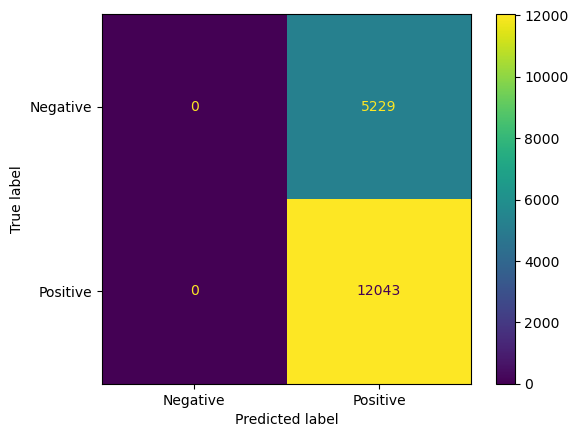

In [16]:
# creating a confusion matrix for our baseline dummy model 
ConfusionMatrixDisplay.from_predictions(y_test,preds,display_labels=['Negative','Positive'])

In [17]:
dummy_pipe.score(X_test,y_test)

0.6972556739231126

### Precision-Recall AUC (PR-AUC)

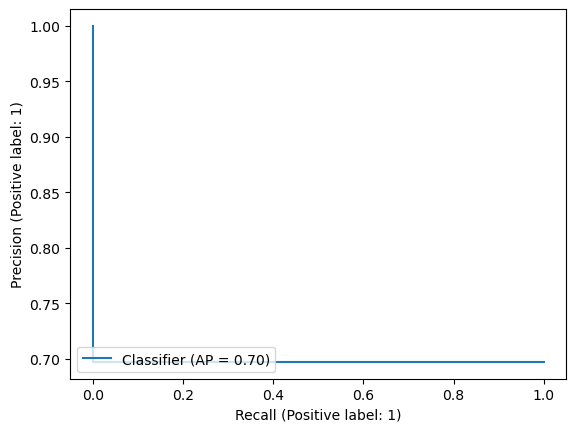

In [18]:
# plotting the precision-recall curve 
PrecisionRecallDisplay.from_predictions(y_test, preds)

### ROC-AUC Curve

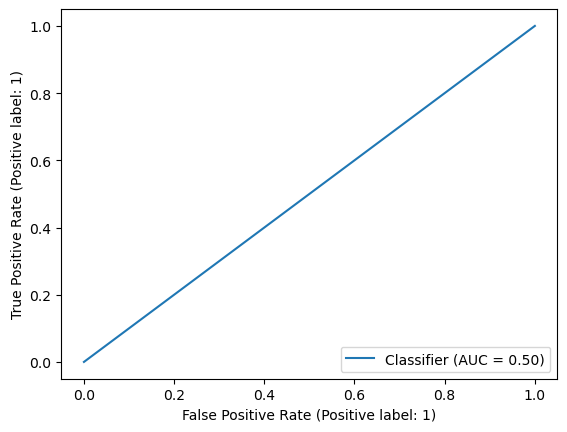

In [19]:
RocCurveDisplay.from_predictions(y_test, preds)

### Classification Report

In [20]:
print(classification_report(y_test,preds,target_names=class_labels,zero_division=1))

              precision    recall  f1-score   support

    Negative       1.00      0.00      0.00      5229
    Positive       0.70      1.00      0.82     12043

    accuracy                           0.70     17272
   macro avg       0.85      0.50      0.41     17272
weighted avg       0.79      0.70      0.57     17272



Our dummy model has a baseline accuracy of 70%, which is okay. 

## RandomForestClassifier

For our first model, we'll use `RandomForestClassifier`!

In [21]:
#imports
from sklearn.ensemble import RandomForestClassifier

In [21]:
rf_pipe = deepcopy(preprocess_pipeline)
rf_pipe.steps.append(('rf_clf',RandomForestClassifier(random_state=42)))
rf_pipe

Pipeline(steps=[('tfdif', TfidfVectorizer()),
                ('rf_clf', RandomForestClassifier(random_state=42))])

In [22]:
rf_pipe.fit(X_train,y_train)

Pipeline(steps=[('tfdif', TfidfVectorizer()),
                ('rf_clf', RandomForestClassifier(random_state=42))])

In [23]:
# extracting our predictions 
preds2 = rf_pipe.predict(X_test)

### Confusion Matrix Display

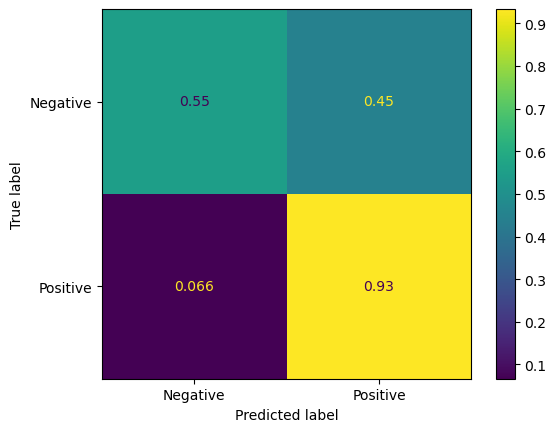

In [24]:
ConfusionMatrixDisplay.from_predictions(y_test, preds2,normalize='true',display_labels=class_labels)

In [25]:
rf_pipe.score(X_test,y_test)

0.818723946271422

### Classification Report 

In [26]:
print(classification_report(y_test,preds2))

              precision    recall  f1-score   support

           0       0.78      0.55      0.65      5229
           1       0.83      0.93      0.88     12043

    accuracy                           0.82     17272
   macro avg       0.81      0.74      0.76     17272
weighted avg       0.81      0.82      0.81     17272



### ROC 

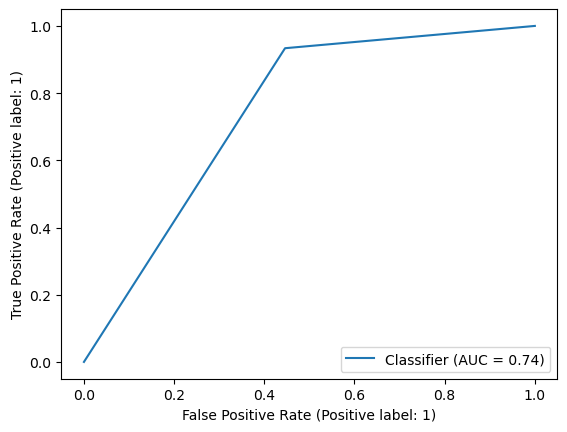

In [27]:
RocCurveDisplay.from_predictions(y_test,preds2)

### Precision-Recall Curve

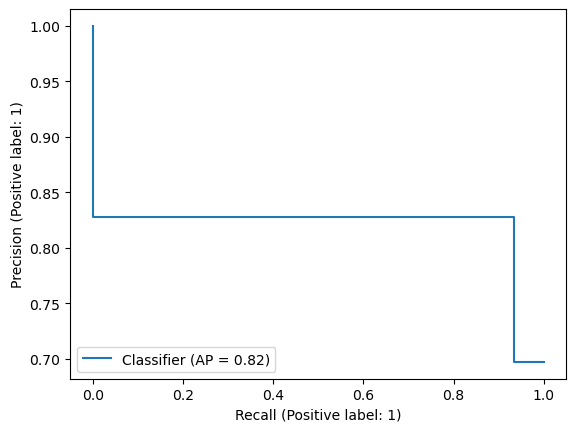

In [28]:
PrecisionRecallDisplay.from_predictions(y_test,preds2)

## Model Tuning

In [29]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [31]:
rf_rcv_params = {'tfdif__min_df':[.01,.03,.05],
                 'tfdif__max_df':[.85,.90,.95],
                 'rf_clf__n_estimators':[50,100,150],
                 'rf_clf__max_features':[1e-2,1e-1,1]}

In [32]:
# avg run-time : 28 min
rf_random_cv = RandomizedSearchCV(estimator=rf_pipe,
                               param_distributions=rf_rcv_params,
                               cv=5)
rf_random_cv.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfdif', TfidfVectorizer()),
                                             ('rf_clf',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'rf_clf__max_features': [0.01, 0.1, 1],
                                        'rf_clf__n_estimators': [50, 100, 150],
                                        'tfdif__max_df': [0.85, 0.9, 0.95],
                                        'tfdif__min_df': [0.01, 0.03, 0.05]})

In [33]:
best_rf_preds = rf_random_cv.predict(X_test)

### Classification Report

In [34]:
print(classification_report(y_test,best_rf_preds))

              precision    recall  f1-score   support

           0       0.70      0.62      0.66      5229
           1       0.84      0.89      0.86     12043

    accuracy                           0.80     17272
   macro avg       0.77      0.75      0.76     17272
weighted avg       0.80      0.80      0.80     17272



### ROC-AUC Curve

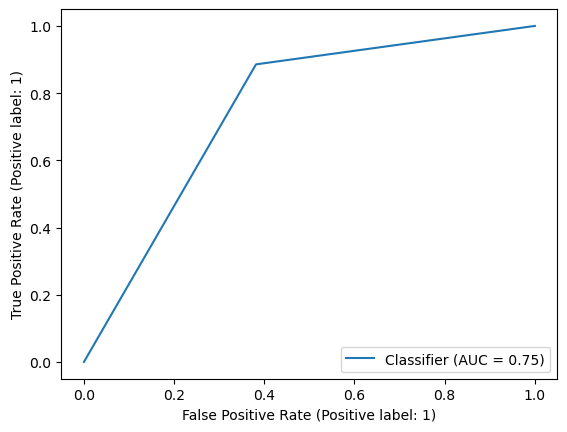

In [35]:
RocCurveDisplay.from_predictions(y_test,best_rf_preds)

### Precision-Recall Curve

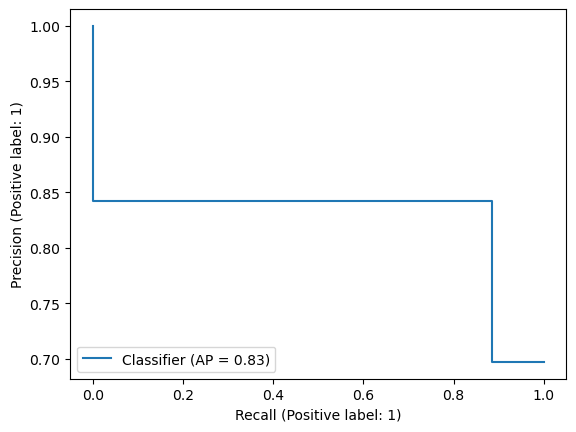

In [36]:
PrecisionRecallDisplay.from_predictions(y_test,best_rf_preds)

## Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression

In [23]:
log_pipe = deepcopy(preprocess_pipeline)
log_pipe.steps.append(('log_reg',LogisticRegression(random_state=418)))
log_pipe

Pipeline(steps=[('tfdif', TfidfVectorizer()),
                ('log_reg', LogisticRegression(random_state=418))])

In [24]:
log_pipe.fit(X_train,y_train)

C:\Users\devin\anaconda3\envs\spotify-project\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfdif', TfidfVectorizer()),
                ('log_reg', LogisticRegression(random_state=418))])

Our model with default params did not converge! In our model-tuning steps, we'll use `RandomziedSearchCV` to optimize for different `max_iters`.

In [25]:
preds3 = log_pipe.predict(X_test)

### Confusion  Matrix Display

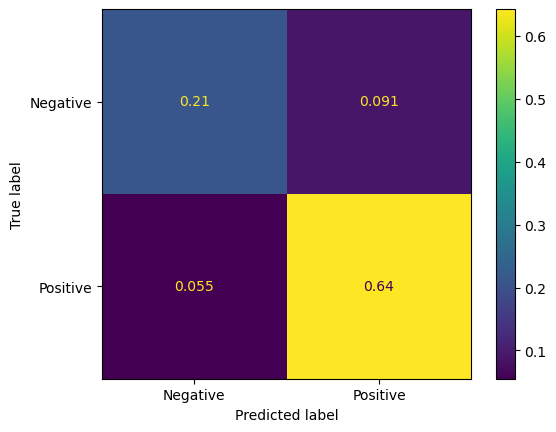

In [26]:
ConfusionMatrixDisplay.from_predictions(y_test, preds3,normalize='all',display_labels=class_labels)

### Classification Report

In [27]:
print(classification_report(y_test,preds3))

              precision    recall  f1-score   support

           0       0.79      0.70      0.74      5229
           1       0.88      0.92      0.90     12043

    accuracy                           0.85     17272
   macro avg       0.83      0.81      0.82     17272
weighted avg       0.85      0.85      0.85     17272



### ROC 

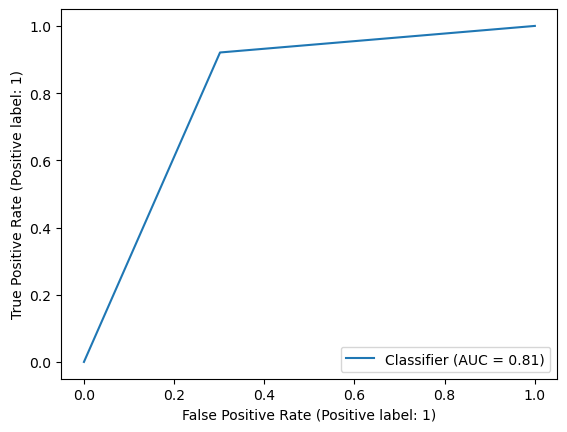

In [28]:
RocCurveDisplay.from_predictions(y_test,preds3)

### Precision-Recall Curve

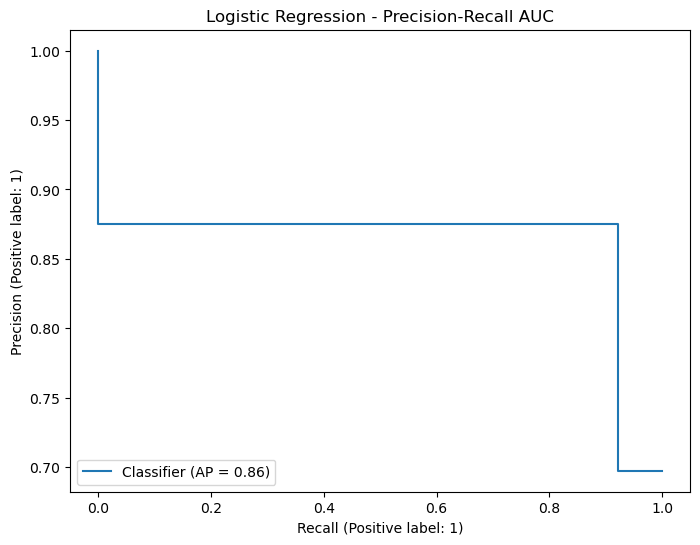

In [29]:
fig,ax = plt.subplots(figsize=(8,6))
ax = PrecisionRecallDisplay.from_predictions(y_test,preds3,ax=ax)
plt.title("Logistic Regression - Precision-Recall AUC")
plt.tight_layout
plt.savefig('images/log_model_pr_auc.png',dpi=300)

## Hyperparameter Tuning

In [30]:
log_pipe.steps

[('tfdif', TfidfVectorizer()),
 ('log_reg', LogisticRegression(random_state=418))]

In [31]:
random_cv_params = {'tfdif__min_df':[.01,.03,.05],
                    'tfdif__max_df':[.85,.90,.95],
                    'log_reg__C':[1e-3,1e-2,1e-1,1,1.01,1.1,1e1],
                    'log_reg__max_iter':[100,120,140]}

In [32]:
random_cv = RandomizedSearchCV(estimator=log_pipe,
                               param_distributions=random_cv_params,
                               cv=5)
random_cv.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfdif', TfidfVectorizer()),
                                             ('log_reg',
                                              LogisticRegression(random_state=418))]),
                   param_distributions={'log_reg__C': [0.001, 0.01, 0.1, 1,
                                                       1.01, 1.1, 10.0],
                                        'log_reg__max_iter': [100, 120, 140],
                                        'tfdif__max_df': [0.85, 0.9, 0.95],
                                        'tfdif__min_df': [0.01, 0.03, 0.05]})

In [33]:
best_log_preds = random_cv.best_estimator_.predict(X_test)

### Classification Report

In [34]:
print(classification_report(y_test,best_log_preds))

              precision    recall  f1-score   support

           0       0.71      0.64      0.67      5229
           1       0.85      0.89      0.87     12043

    accuracy                           0.81     17272
   macro avg       0.78      0.76      0.77     17272
weighted avg       0.81      0.81      0.81     17272



### ROC-AUC Curve

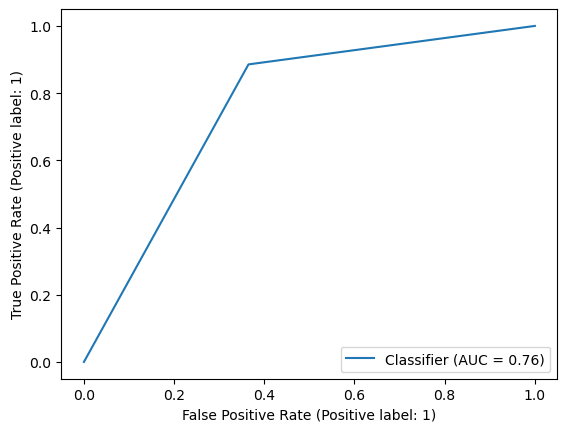

In [35]:
RocCurveDisplay.from_predictions(y_test,best_log_preds)

### Precision-Recall Curve

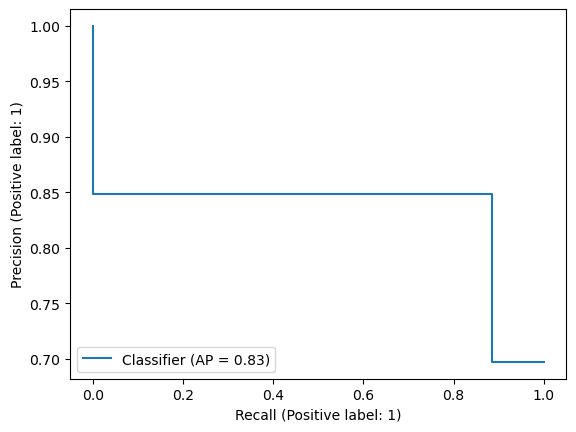

In [36]:
PrecisionRecallDisplay.from_predictions(y_test,best_log_preds)

In [440]:
pd.DataFrame(random_cv.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tfdif__min_df,param_tfdif__max_df,param_log_reg__max_iter,param_log_reg__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.547855,0.014531,0.105070,0.009579,0.01,0.9,100,10.0,"{'tfdif__min_df': 0.01, 'tfdif__max_df': 0.9, ...",0.805235,0.807196,0.812779,0.818859,0.818610,0.812536,0.005635,1
9,0.526409,0.019688,0.103518,0.007083,0.01,0.95,140,1.1,"{'tfdif__min_df': 0.01, 'tfdif__max_df': 0.95,...",0.806848,0.807320,0.811042,0.817742,0.817866,0.812164,0.004829,2
3,0.600214,0.113351,0.110679,0.008711,0.01,0.85,140,1.01,"{'tfdif__min_df': 0.01, 'tfdif__max_df': 0.85,...",0.807220,0.807196,0.811042,0.817246,0.817990,0.812139,0.004694,3
6,0.636544,0.050046,0.112314,0.011598,0.01,0.9,140,1,"{'tfdif__min_df': 0.01, 'tfdif__max_df': 0.9, ...",0.807220,0.807196,0.811042,0.817246,0.817866,0.812114,0.004663,4
7,0.549220,0.031344,0.122538,0.018184,0.03,0.9,120,10.0,"{'tfdif__min_df': 0.03, 'tfdif__max_df': 0.9, ...",0.769756,0.769727,0.771712,0.777295,0.778660,0.773430,0.003807,5


The results from `RandomizedSearchCV` did not improve model performance. 

## Multinomial Naive Bayes

In [47]:
from sklearn.naive_bayes import MultinomialNB

In [48]:
multiNB_pipe = deepcopy(preprocess_pipeline)
multiNB_pipe.steps.append(('multiNB',MultinomialNB()))
multiNB_pipe

Pipeline(steps=[('tfdif', TfidfVectorizer()), ('multiNB', MultinomialNB())])

In [49]:
multiNB_pipe.fit(X_train,y_train)

Pipeline(steps=[('tfdif', TfidfVectorizer()), ('multiNB', MultinomialNB())])

In [50]:
preds4 = multiNB_pipe.predict(X_test)

### Classification Report 

In [51]:
print(classification_report(y_test, preds4))

              precision    recall  f1-score   support

           0       0.78      0.36      0.49      5229
           1       0.77      0.96      0.86     12043

    accuracy                           0.78     17272
   macro avg       0.78      0.66      0.67     17272
weighted avg       0.78      0.78      0.75     17272



### Confusion Matrix Display

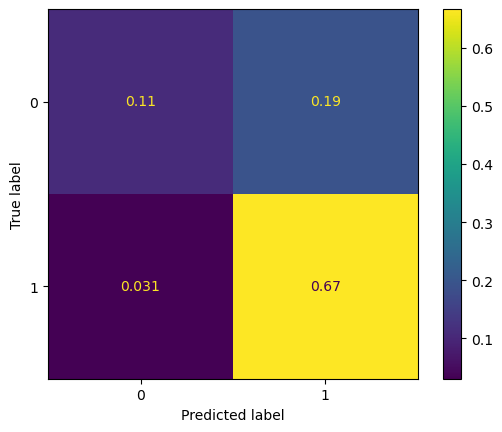

In [52]:
ConfusionMatrixDisplay.from_predictions(y_test, preds4,normalize='all')

### ROC-AUC Curve

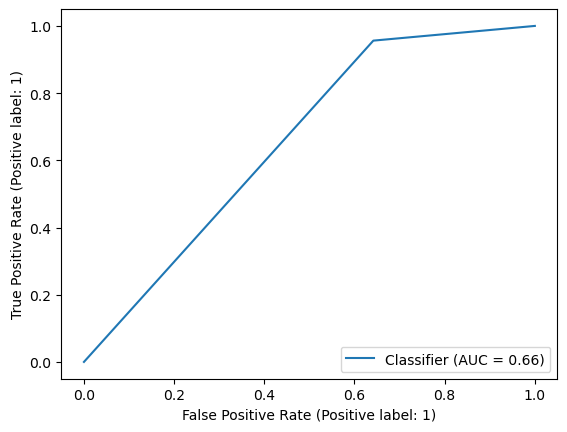

In [301]:
RocCurveDisplay.from_predictions(y_test,preds4)

### Precision-Recall Curve

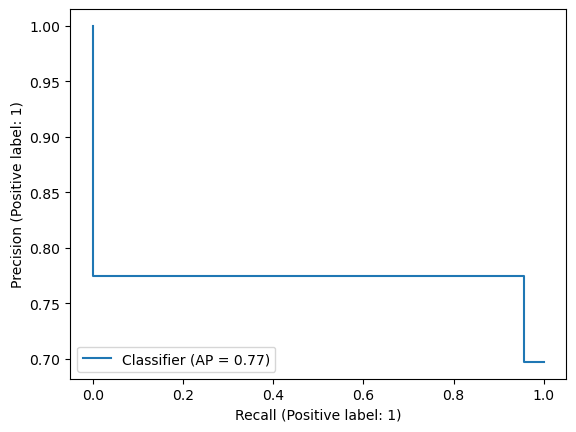

In [53]:
PrecisionRecallDisplay.from_predictions(y_test,preds4)

## Hyperparameter Tuning

In [300]:
multinb_rcv_params = {'tfdif__min_df':[.01,.03,.05],
                    'tfdif__max_df':[.85,.90,.95],
                    'multiNB__alpha':[1e-2, 1e-1, 1, 1e1,1e2]}

In [311]:
multinb_rcv_pipe = RandomizedSearchCV(estimator=multiNB_pipe,
                               param_distributions=multinb_rcv_params,
                               cv=5)

In [312]:
multinb_rcv_pipe.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfdif', TfidfVectorizer()),
                                             ('multiNB', MultinomialNB())]),
                   param_distributions={'multiNB__alpha': [0.01, 0.1, 1, 10.0,
                                                           100.0],
                                        'tfdif__max_df': [0.85, 0.9, 0.95],
                                        'tfdif__min_df': [0.01, 0.03, 0.05]})

In [313]:
best_multinb_preds = multinb_rcv_pipe.predict(X_test)

In [308]:
MultinomialNB().get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}

### Classification Report

In [314]:
print(classification_report(y_test,best_multinb_preds))

              precision    recall  f1-score   support

           0       0.68      0.44      0.53      5229
           1       0.79      0.91      0.85     12043

    accuracy                           0.77     17272
   macro avg       0.74      0.67      0.69     17272
weighted avg       0.76      0.77      0.75     17272



### ROC-AUC Curve

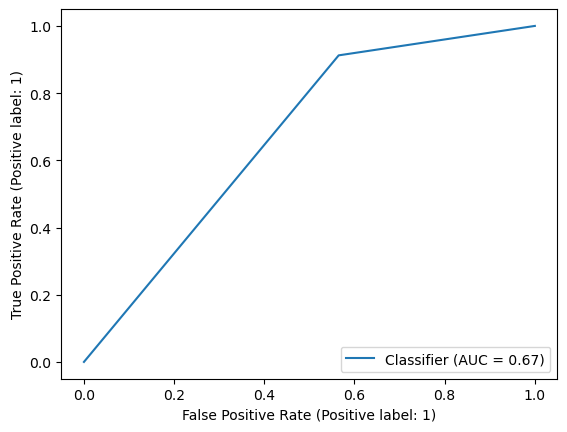

In [315]:
RocCurveDisplay.from_predictions(y_test,best_multinb_preds)

### Precision-Recall Curve

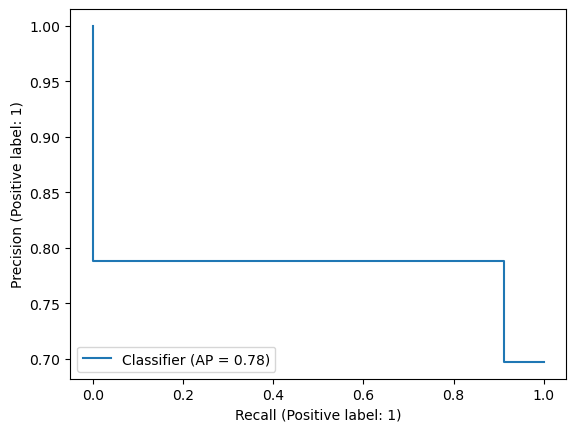

In [316]:
PrecisionRecallDisplay.from_predictions(y_test,best_multinb_preds)

## Complement Naive Bayes

In [54]:
from sklearn.naive_bayes import ComplementNB

In [55]:
compNB_pipe = deepcopy(preprocess_pipeline)
compNB_pipe.steps.append(('compNB',ComplementNB()))
compNB_pipe

Pipeline(steps=[('tfdif', TfidfVectorizer()), ('compNB', ComplementNB())])

In [56]:
compNB_pipe.fit(X_train,y_train)

Pipeline(steps=[('tfdif', TfidfVectorizer()), ('compNB', ComplementNB())])

In [57]:
preds5 = compNB_pipe.predict(X_test)

In [58]:
print(classification_report(y_test, preds5))

              precision    recall  f1-score   support

           0       0.63      0.76      0.69      5229
           1       0.88      0.81      0.84     12043

    accuracy                           0.79     17272
   macro avg       0.76      0.78      0.77     17272
weighted avg       0.81      0.79      0.80     17272



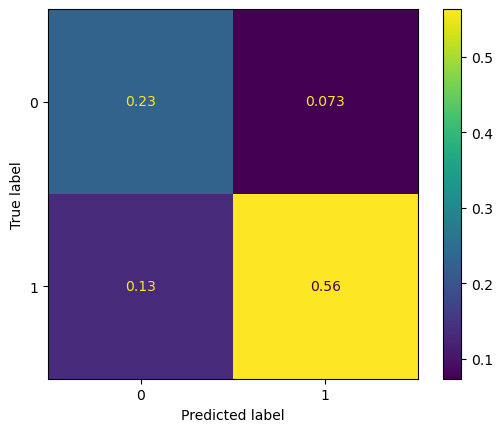

In [59]:
ConfusionMatrixDisplay.from_predictions(y_test, preds5,normalize='all')

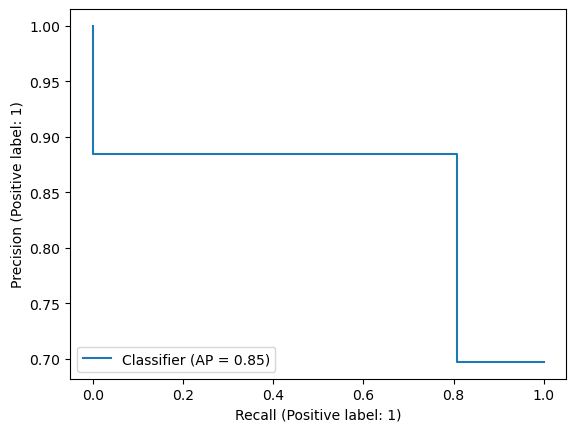

In [60]:
PrecisionRecallDisplay.from_predictions(y_test,preds5)

## Hyperparameter Tuning

In [318]:
compNB_rcv_params = {'tfdif__min_df':[.01,.03,.05],
                    'tfdif__max_df':[.85,.90,.95],
                    'compNB__alpha':[1e-2, 1e-1, 1, 1e1,1e2]}

In [320]:
compNB_rcv_pipe = RandomizedSearchCV(estimator=compNB_pipe,
                               param_distributions=compNB_rcv_params,
                               cv=5)

In [321]:
compNB_rcv_pipe.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfdif', TfidfVectorizer()),
                                             ('compNB', ComplementNB())]),
                   param_distributions={'compNB__alpha': [0.01, 0.1, 1, 10.0,
                                                          100.0],
                                        'tfdif__max_df': [0.85, 0.9, 0.95],
                                        'tfdif__min_df': [0.01, 0.03, 0.05]})

In [322]:
best_compNB_preds = compNB_rcv_pipe.predict(X_test)

### Classification Report

In [323]:
print(classification_report(y_test,best_compNB_preds))

              precision    recall  f1-score   support

           0       0.57      0.78      0.65      5229
           1       0.88      0.74      0.81     12043

    accuracy                           0.75     17272
   macro avg       0.72      0.76      0.73     17272
weighted avg       0.79      0.75      0.76     17272



### ROC-AUC Curve

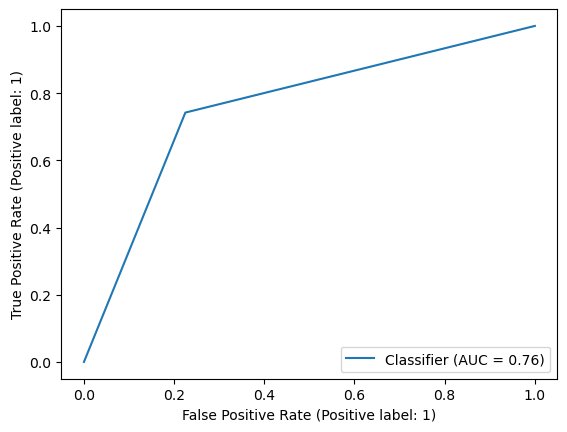

In [324]:
RocCurveDisplay.from_predictions(y_test,best_compNB_preds)

### Precision-Recall Curve

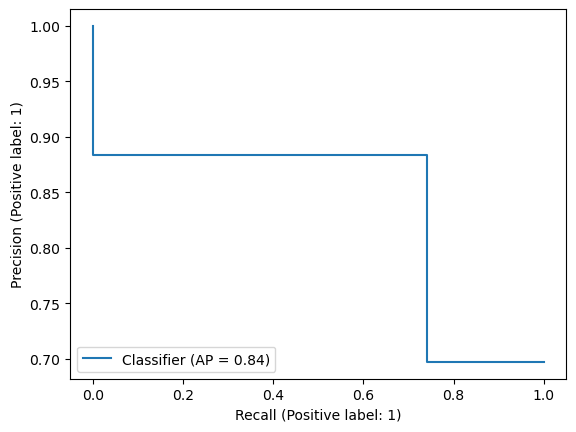

In [325]:
PrecisionRecallDisplay.from_predictions(y_test,best_compNB_preds)

## Bernoulli Naive Bayes

In [326]:
from sklearn.naive_bayes import BernoulliNB

In [327]:
bernoulliNB_pipe = deepcopy(preprocess_pipeline)
bernoulliNB_pipe.steps.append(('bernoulliNB',BernoulliNB()))
bernoulliNB_pipe

Pipeline(steps=[('tfdif', TfidfVectorizer()), ('bernoulliNB', BernoulliNB())])

In [328]:
bernoulliNB_pipe.fit(X_train,y_train)

Pipeline(steps=[('tfdif', TfidfVectorizer()), ('bernoulliNB', BernoulliNB())])

In [329]:
preds7 = bernoulliNB_pipe.predict(X_test)

### Classification Report 

In [330]:
print(classification_report(y_test, preds7))

              precision    recall  f1-score   support

           0       0.61      0.60      0.60      5229
           1       0.83      0.83      0.83     12043

    accuracy                           0.76     17272
   macro avg       0.72      0.72      0.72     17272
weighted avg       0.76      0.76      0.76     17272



### Confusion Matrix Display

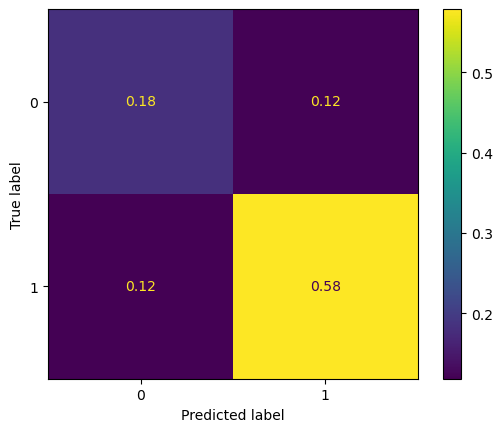

In [331]:
ConfusionMatrixDisplay.from_predictions(y_test, preds7,normalize='all')

### ROC-AUC Curve

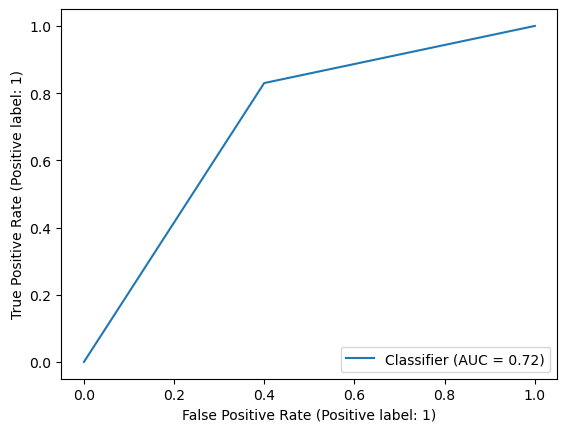

In [332]:
RocCurveDisplay.from_predictions(y_test,preds7)

### Precision-Recall Curve

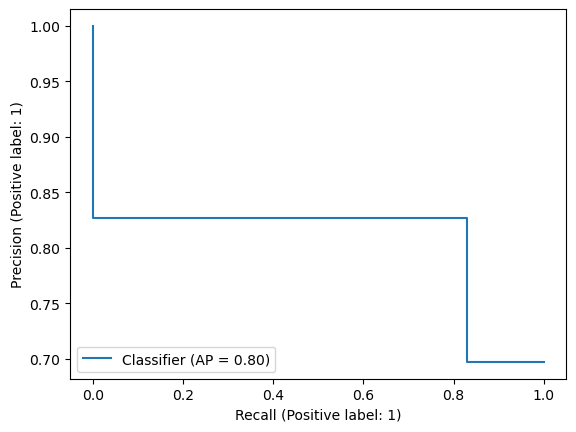

In [333]:
PrecisionRecallDisplay.from_predictions(y_test,preds7)

## XGBoost Model 

In [334]:
from xgboost import XGBClassifier

In [335]:
xgb_pipe = deepcopy(preprocess_pipeline)
xgb_pipe.steps.append(('xgbModel',XGBClassifier(random_state=42)))
xgb_pipe

Pipeline(steps=[('tfdif', TfidfVectorizer()),
                ('xgbModel',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [336]:
xgb_pipe.fit(X_train,y_train)
preds6 = xgb_pipe.predict(X_test)

### Classification Report

In [337]:
print(classification_report(y_test, preds6))

              precision    recall  f1-score   support

           0       0.78      0.64      0.71      5229
           1       0.86      0.92      0.89     12043

    accuracy                           0.84     17272
   macro avg       0.82      0.78      0.80     17272
weighted avg       0.83      0.84      0.83     17272



### Confusion Matrix Display

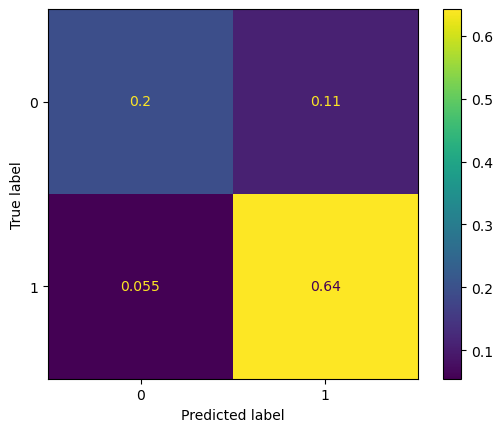

In [338]:
ConfusionMatrixDisplay.from_predictions(y_test, preds6,normalize='all')

### Precision-Recall AUC

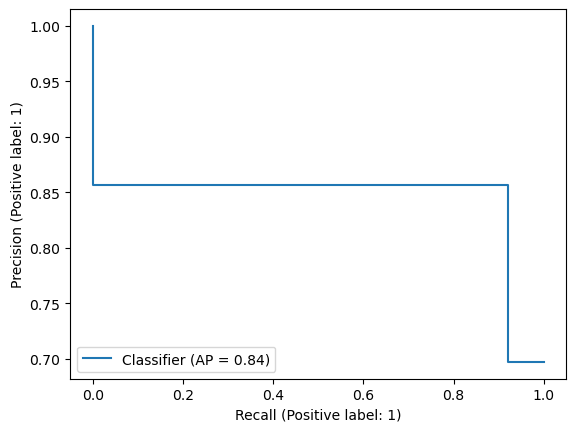

In [339]:
PrecisionRecallDisplay.from_predictions(y_test,preds6)

In [340]:
xgb_params = {'tfdif__min_df':[.01,.03,.05],
              'tfdif__max_df':[.85,.90,.95],
              'xgbModel__max_depth': [3,4, 5], 
              'xgbModel__learning_rate': [.1, .3, .5],
              'xgbModel__gamma': [0,5,10], 
              'xgbModel__n_estimators': [50,100, 150] }

In [341]:
xgb_rcv_pipe = RandomizedSearchCV(estimator=xgb_pipe,
                                  param_distributions=xgb_params,
                                 cv=5)

In [342]:
xgb_rcv_pipe.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfdif', TfidfVectorizer()),
                                             ('xgbModel',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_types=None,
                                                            gamma=None,
                                                            gpu_id=None,
                                                            grow_policy=None,
                                                            importa...
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            n_estimators=100,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            predictor=None,
                                                            random_state=42, ...))]),
                   param_distributions={'tfdif__max_df': [0.85, 0.9, 0.95],
                                        'tfdif__min_df': [0.01, 0.03, 0.05],
                                        'xgbModel__gamma': [0, 5, 10],
                                        'xgbModel__learning_rate': [0.1, 0.3,
                                                                    0.5],
                                        'xgbModel__max_depth': [3, 4, 5],
                                        'xgbModel__n_estimators': [50, 100,
                                                                   150]})

In [343]:
best_xgb_preds = xgb_rcv_pipe.predict(X_test)

### Classification Report

In [346]:
print(classification_report(y_test, best_xgb_preds))

              precision    recall  f1-score   support

           0       0.72      0.59      0.65      5229
           1       0.84      0.90      0.87     12043

    accuracy                           0.81     17272
   macro avg       0.78      0.75      0.76     17272
weighted avg       0.80      0.81      0.80     17272



### Confusion Matrix Display

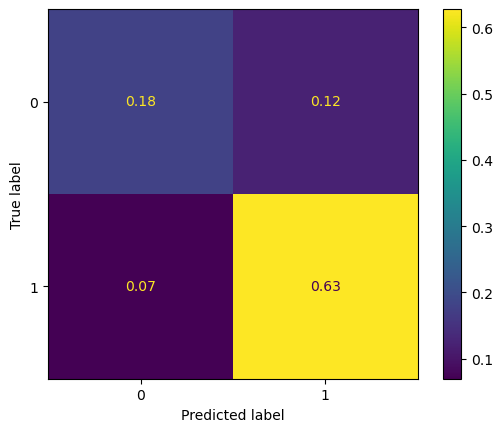

In [345]:
ConfusionMatrixDisplay.from_predictions(y_test, best_xgb_preds,normalize='all')

### ROC-AUC 

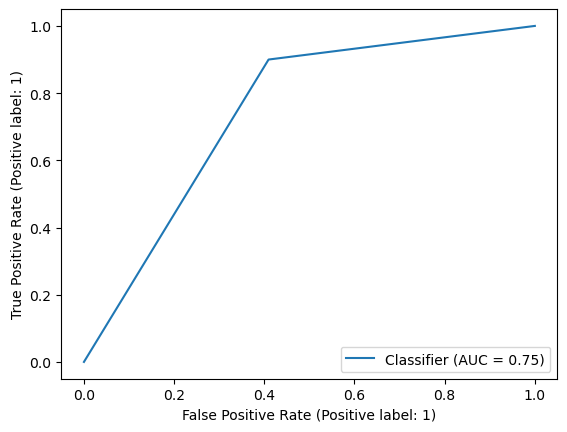

In [347]:
RocCurveDisplay.from_predictions(y_test, best_xgb_preds)

### Precision-Recall AUC

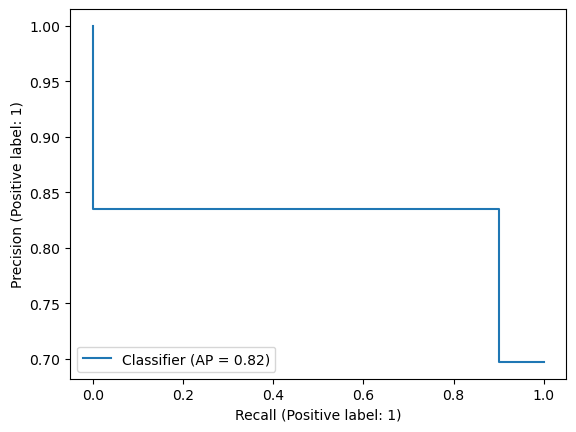

In [344]:
PrecisionRecallDisplay.from_predictions(y_test,best_xgb_preds)

**BEST MODEL**:

Using our evaluation criteria, the best model is a logistic regression without hyperparameter tuning:
- accuracy: .86
- macro_f1_score: .82 

###  Feature Importance (Noun Phrases)

So we've identified that our best model is a `LogisticRegresssion` with default params -- what next?

In [37]:
words = random_cv.best_estimator_.steps[0][1].vocabulary_
word_importance = random_cv.best_estimator_.named_steps['log_reg'].coef_
word_importance = np.unique(word_importance)
important_words = list(zip(words,word_importance))

In [40]:
word_map = [(x,words[x]) for x in words]
word_map.sort(key=lambda x:x[1])

In [41]:
imp_vocab = [x[0] for x in word_map]

# number of unique words models considered as part of their vocabulary 
len(imp_vocab)

239

In [46]:
imp_words = str(imp_vocab)
imp_words = imp_words.replace("\'","").replace("[","").replace("]","").replace(","," ")

In [47]:
from textblob import TextBlob

In [50]:
imp_words_blob = TextBlob(imp_words)
imp_nouns = imp_words_blob.noun_phrases

In [51]:
imp_nouns_list = []
for noun in imp_nouns:
    imp_nouns_list.append(noun.replace(' ','_'))
imp_nouns_str = ' '.join(imp_nouns_list)

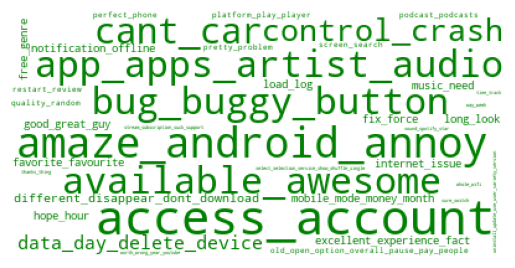

In [54]:
nouns_wc = WordCloud(background_color='white',color_func=lambda *args, **kwargs: "green")
nouns_wc.generate_from_text(imp_nouns_str)
plt.imshow(nouns_wc)
plt.axis('off')
plt.savefig('images/important_noun_phrases.png',dpi=300)

In [55]:
# using these noun phrases our model considered important, 
# lets read some of the reviews that mention "android"
spotify_df[spotify_df.review.str.contains('android')].review.values

array(['this pop-up "get the best spotify experience on android 12" is too annoying. please let\'s get rid of this.',
       'android user - there are loads of glitches with this app... player bar disappears, shuffle button missing....sort it out please',
       'work really well with android auto on those long drives home.',
       ...,
       "unstable app through multiple updates, different devices, android and ios, etc. crashes, freezes, lags, bugs in playback/pause. the irony of frequent premium account upsells during this experience is poignant; do the crashes stop if i pay a monthly fee?! doubtful! if it weren't for the exclusive podcasts, i would abandon spotify altogether. and neverending, pointless recommendations, adds, etc. google/apple podcast apps are superior.",
       "i've had this app for years and it works great on both iphone and android. it's super easy to use and organize. i pay monthly to avoid commercials because it's definitely worth it. there's just no better 

So, we have our important noun phrases that our model considered importanc

In [57]:
imp_word_coef = list(zip(imp_vocab,word_importance))
correct_df = pd.DataFrame(imp_word_coef, columns=['word', 'coef'])
correct_df.sort_values('coef',ascending=False).head(5)

,word,coef
238,youtube,7.590022
237,year,7.125250
236,wrong,6.685694
235,worth,5.633947
234,work,5.181105


In [59]:
correct_df.sort_values('coef',ascending=False).tail(5)

,word,coef
4,actually,-4.010923
3,account,-4.260612
2,access,-4.418157
1,absolutely,-5.233637
0,able,-5.862684


In [60]:
positive_dict = {x[0]:x[1] for x in imp_word_coef}

In [103]:
from wordcloud import STOPWORDS
stop_wrds = list(STOPWORDS) + ["absolutely","already","actually"]

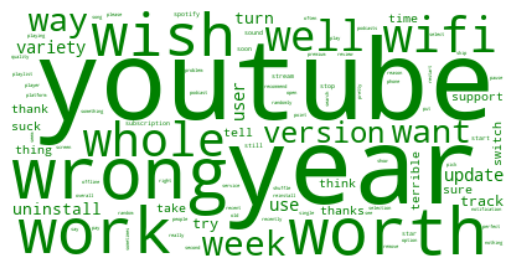

In [98]:
wordcloud = WordCloud(background_color='white',
                      color_func=lambda *args, **kwargs: "green",stopwords=stop_wrds)
wordcloud.generate_from_frequencies(positive_dict)
plt.axis('off')
plt.imshow(wordcloud,interpolation='bilinear')

## Negative Reviews Feature Importance

In [99]:
neg_words = list(zip(imp_vocab,word_importance*-1))
negative_dict = {x[0]:x[1] for x in neg_words}

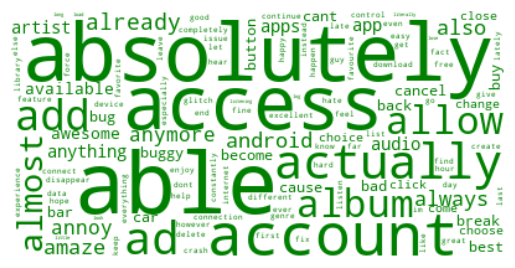

In [106]:
wc = WordCloud(background_color='white',
                      color_func=lambda *args, **kwargs: "green",stopwords=stop_wrds)
wc.generate_from_frequencies(negative_dict)
plt.axis('off')
plt.imshow(wc,interpolation='bilinear')

In [84]:
# creating a dataframe with words and their coefs 
imp_words_df = pd.DataFrame(important_words, columns=['Word', 'Weight'])
imp_words_df.sort_values('Weight',ascending=False).head(10)

,Word,Weight
238,whole,7.590022
237,end,7.125250
236,disappear,6.685694
235,break,5.633947
234,uninstall,5.181105
233,perfect,5.087653
232,lately,5.076917
231,late,4.723050
230,old,4.628679
229,however,4.596922


In [154]:
imp_words_df.sort_values(by='Weight',ascending=False).tail()

,Word,Weight
4,see,-3.654224
3,premium,-3.883971
2,buy,-4.202810
1,ad,-4.863029
0,hate,-5.554982


In [146]:
# top ten words with the highest negative correlation to target label 
# these words have an inverse relationship with classifying a review as positive or negative
imp_words_df.sort_values(by='Weight',ascending=False).tail(10)

,Word,Weight
9,good,-1.722023
8,ever,-2.252735
7,thing,-2.477261
6,app,-2.954690
5,sure,-3.488765
4,see,-3.654224
3,premium,-3.883971
2,buy,-4.202810
1,ad,-4.863029
0,hate,-5.554982


In [156]:
coef_dict = {x[0]:x[1] for x in important_words}

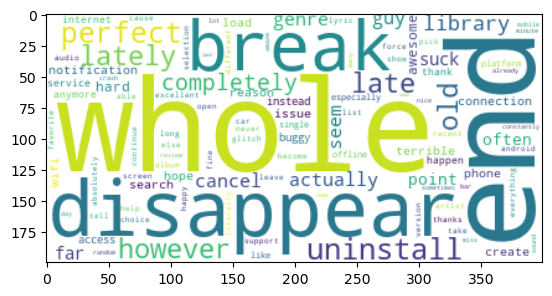

In [163]:
wordcloud = WordCloud(background_color='white')

wordcloud.generate_from_frequencies(coef_dict)
plt.imshow(wordcloud,interpolation='bilinear')

In [165]:
neg_coef_list = list(zip(words,word_importance*-1))
neg_coef_dict = {x[0]:x[1] for x in important_words}

In [219]:
neg_coef_dict

{'hate': -5.554982081105348,
 'ad': -4.863028724262688,
 'buy': -4.202810169197359,
 'premium': -3.883970578662337,
 'see': -3.6542236617827717,
 'sure': -3.4887652565147413,
 'app': -2.9546895421607426,
 'thing': -2.4772614718571857,
 'ever': -2.252734748478559,
 'good': -1.7220232493647558,
 'apps': -1.5902901312380329,
 'think': -1.428471891139951,
 'play': -1.4029603210008887,
 'dont': -1.3745560398032197,
 'download': -1.3282312261375142,
 'spotify': -1.2000761113883511,
 'well': -1.1775147185005417,
 'listen': -1.128402646417748,
 'track': -1.1102101324004554,
 'favourite': -1.1050685837194474,
 'connect': -1.098725565600058,
 'year': -1.0353550978182442,
 'add': -0.9286782746082476,
 'skip': -0.9176488287583757,
 'come': -0.8357239364653821,
 'fix': -0.8312054885753737,
 'great': -0.7833020043614004,
 'enjoy': -0.7613549810617652,
 'also': -0.7289827900327743,
 'free': -0.7287840858101163,
 'month': -0.7179807698534889,
 'cant': -0.7169025061151876,
 'even': -0.7086070758134939,

In [451]:
wordcloud = WordCloud(background_color='white', color_func=lambda *args, **kwargs: "green")

wordcloud.generate_from_frequencies(neg_coef_dict)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

NameError: name 'neg_coef_dict' is not defined

# COUNT VECTORIZER WITH BIGRAMS

In [265]:
bigram_pipe = deepcopy(preprocess_pipeline)
bigram_pipe.steps[0] = ('count_vec',CountVectorizer(ngram_range=(2,2),min_df=.001,max_df=.9,stop_words=custom_stpwrds))
bigram_pipe

Pipeline(steps=[('count_vec',
                 CountVectorizer(max_df=0.9, min_df=0.001, ngram_range=(2, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...]))])

In [268]:
bigram_pipe.fit_transform(X_train)
bow_cv = bigram_pipe.fit_transform(X_train).toarray()
columns = bigram_pipe.get_feature_names_out()
bigrams_df = pd.DataFrame(data=bow_cv, columns=columns)
bigrams_df.shape

(40301, 1104)

In [294]:
count_vectorizer = CountVectorizer(min_df=.001,max_df=.9)
bow_2 = count_vectorizer.fit_transform(X_train).toarray()
columns_2 = count_vectorizer.get_feature_names_out()
unigrams_df = pd.DataFrame(data=bow_2, columns=columns_2)
unigrams_df.shape

(40301, 1138)

In [285]:
X_train_uni_bi = pd.concat([bigrams_df,unigrams_df],axis=1)

In [287]:
log_Model = LogisticRegression(random_state=1248)

In [299]:
log_Model.fit(X_train_uni_bi,y_train)

C:\Users\Kevin\anaconda3\envs\spotify-proj\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=1248)

In [295]:
# need to do the same thing to X_test 
bigram_pipe.fit_transform(X_test)
test_bow_cv = bigram_pipe.fit_transform(X_test).toarray()
test_columns = bigram_pipe.get_feature_names_out()
test_bigrams_df = pd.DataFrame(data=test_bow_cv, columns=test_columns)
test_bigrams_df.shape

(17272, 1142)

In [308]:
count_vectorizer = CountVectorizer(min_df=.001,max_df=.9)
test_bow_2 = count_vectorizer.fit_transform(X_test).toarray()
test_columns_2 = count_vectorizer.get_feature_names_out()
test_unigrams_df = pd.DataFrame(data=test_bow_2, columns=test_columns_2)
test_unigrams_df.shape

(17272, 1116)

In [309]:
X_test_uni_bi = pd.concat([test_bigrams_df,test_unigrams_df],axis=1)

In [310]:
X_test_uni_bi.columns

Index(['able find', 'able listen', 'able play', 'able see', 'able use',
       'absolutely love', 'access music', 'actually play', 'actually want',
       'ad ad',
       ...
       'ya', 'yall', 'yeah', 'year', 'yes', 'yesterday', 'yet', 'young',
       'youtube', 'yt'],
      dtype='object', length=2258)

In [311]:
X_train_uni_bi.columns

Index(['able find', 'able listen', 'able play', 'able see', 'absolutely love',
       'access music', 'actually play', 'ad ad', 'ad also', 'ad annoy',
       ...
       'ya', 'yall', 'yeah', 'year', 'yes', 'yesterday', 'yet', 'young',
       'youtube', 'yt'],
      dtype='object', length=2242)

In [202]:
bigram_preds = bigram_pipe.predict(X_test)

In [203]:
print(classification_report(y_test,bigram_preds))

              precision    recall  f1-score   support

           0       0.64      0.12      0.20      5229
           1       0.72      0.97      0.83     12043

    accuracy                           0.71     17272
   macro avg       0.68      0.54      0.51     17272
weighted avg       0.69      0.71      0.64     17272



In [ ]:
# testing something 

In [60]:
count_vec_pipe = deepcopy(preprocess_pipeline)
count_vec_pipe.steps[0] = ('count_vec',CountVectorizer(ngram_range=(3,3)))
count_vec_pipe.steps.append(('logModel', LogisticRegression(random_state=1105)))
count_vec_pipe

Pipeline(steps=[('count_vec', CountVectorizer(ngram_range=(3, 3))),
                ('logModel', LogisticRegression(random_state=1105))])

In [61]:
count_vec_pipe.fit(X_train,y_train)

C:\Users\Kevin\anaconda3\envs\spotify-proj\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('count_vec', CountVectorizer(ngram_range=(3, 3))),
                ('logModel', LogisticRegression(random_state=1105))])

In [62]:
count_vec_preds = count_vec_pipe.predict(X_test)

In [63]:
print(classification_report(y_test,count_vec_preds))

              precision    recall  f1-score   support

           0       0.65      0.14      0.23      5229
           1       0.72      0.97      0.83     12043

    accuracy                           0.72     17272
   macro avg       0.69      0.55      0.53     17272
weighted avg       0.70      0.72      0.65     17272



In [64]:
print(classification_report(y_test,preds3))

              precision    recall  f1-score   support

           0       0.79      0.70      0.74      5229
           1       0.88      0.92      0.90     12043

    accuracy                           0.85     17272
   macro avg       0.83      0.81      0.82     17272
weighted avg       0.85      0.85      0.85     17272



# TRYING TO ADD BIGRAMS AS FEATURES

In [315]:
def generate_N_grams(text,ngram=1):
  words=[word for word in text.split(" ") if word not in custom_stpwrds]  
  temp=zip(*[words[i:] for i in range(0,ngram)])
  ans=[' '.join(ngram) for ngram in temp]
  return ans

In [316]:
generate_N_grams(text_to_gram,2)

['amount advertising',
 'advertising exploded.',
 'exploded. great',
 'great want',
 'want listen',
 'listen two',
 'two songs,',
 'songs, followed',
 'followed three',
 'three ads.',
 'ads. looking',
 'looking another',
 'another option,',
 'option, definitely',
 'definitely declined',
 'declined recently.']

In [85]:
from nltk import ngrams
from nltk import word_tokenize

In [125]:
X_train_gram = spotify_df[0:5]
y_train_gram = spotify_df.sentiment

In [126]:
X_train_gram

,review,rating,total_thumbs_up,replied,comp_score,pos_score,neg_score,sentiment
0,"great music service, the audio is high quality...",5,2,0,0.9211,0.436,0.000,pos
1,please ignore previous negative rating. this a...,5,1,0,0.6249,0.404,0.243,pos
2,"this pop-up ""get the best spotify experience o...",4,0,0,0.5859,0.258,0.107,pos
3,really buggy and terrible to use as of recently,1,1,0,-0.5209,0.000,0.296,neg
4,dear spotify why do i get songs that i didn't ...,1,1,0,0.7149,0.260,0.000,pos


In [242]:
def create_ngrams(review, ngram=1):
    
    # creating our custom stop words 
    custom_stpwrds = stopwords.words('english')
    custom_stpwrds.extend(['app','spotify'])
    
    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None    
    
    # tokenizing each entry 
    tok =  word_tokenize(review)
    tok = [i.lower() for i in tok if i.isalpha() & (i.lower() not in custom_stpwrds)]
    
    
    # POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
    
    # creates list of tuples with tokens and POS tags in wordnet format
    wn_tags = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(tok))) 
    lem_toks = [wnl.lemmatize(token, pos) for token, pos in wn_tags if pos is not None]
    
    # creating a list of lemmatized bigrams 
    bigrams = list(ngrams(lem_toks,ngram))
    return bigrams

In [243]:
create_ngrams(text_to_gram,2)

[('amount', 'advertising'),
 ('advertising', 'explode'),
 ('explode', 'great'),
 ('great', 'want'),
 ('want', 'listen'),
 ('listen', 'song'),
 ('song', 'follow'),
 ('follow', 'ad'),
 ('ad', 'look'),
 ('look', 'option'),
 ('option', 'definitely'),
 ('definitely', 'decline'),
 ('decline', 'recently')]

In [253]:
X_train_gram.review.apply(create_ngrams,2)[0]

[('great',),
 ('music',),
 ('service',),
 ('audio',),
 ('high',),
 ('quality',),
 ('easy',),
 ('use',),
 ('also',),
 ('quick',),
 ('friendly',),
 ('support',)]

In [212]:
text_to_gram

'the amount of advertising has exploded. this is a great app if you want to listen to two songs, followed by three ads. i am looking for another option, because spotify has definitely declined recently.'

In [215]:
a = word_tokenize(text_to_gram)

In [216]:
for i in a[0:5]:
    print(i)

the
amount
of
advertising
has


In [225]:
pos_tag(a[0:5])

[('the', 'DT'),
 ('amount', 'NN'),
 ('of', 'IN'),
 ('advertising', 'NN'),
 ('has', 'VBZ')]

In [231]:
wnl = WordNetLemmatizer()
wn_tags = list(map(lambda x: (x[0], pos_tagger(x[1])),pos_tag(a)))
good_stuff = [wnl.lemmatize(token, pos) for token, pos in wn_tags if pos is not None]

In [235]:
list(ngrams(good_stuff,2))

[('amount', 'advertising'),
 ('advertising', 'have'),
 ('have', 'explode'),
 ('explode', 'be'),
 ('be', 'great'),
 ('great', 'app'),
 ('app', 'want'),
 ('want', 'listen'),
 ('listen', 'song'),
 ('song', 'follow'),
 ('follow', 'ad'),
 ('ad', 'i'),
 ('i', 'be'),
 ('be', 'look'),
 ('look', 'option'),
 ('option', 'spotify'),
 ('spotify', 'have'),
 ('have', 'definitely'),
 ('definitely', 'decline'),
 ('decline', 'recently')]

In [219]:
#creates list of tuples with tokens and POS tags in wordnet format
#wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(tok))) 
#doc_norm = [wnl.lemmatize(token, pos) for token, pos in wordnet_tagged if pos is not None]

In [220]:
def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None 

In [223]:
pos_tagger(a[1])

In [176]:
text_to_gram

'the amount of advertising has exploded. this is a great app if you want to listen to two songs, followed by three ads. i am looking for another option, because spotify has definitely declined recently.'

In [183]:
create_ngrams(text_to_gram,2)

[('amount', 'advertising'),
 ('advertising', 'exploded'),
 ('exploded', 'great'),
 ('great', 'want'),
 ('want', 'listen'),
 ('listen', 'two'),
 ('two', 'songs'),
 ('songs', 'followed'),
 ('followed', 'three'),
 ('three', 'ads'),
 ('ads', 'looking'),
 ('looking', 'another'),
 ('another', 'option'),
 ('option', 'definitely'),
 ('definitely', 'declined'),
 ('declined', 'recently')]

In [105]:
gram_token = word_tokenize(text_to_gram)

In [107]:
list(ngrams(gram_token,2))

[('the', 'amount'),
 ('amount', 'of'),
 ('of', 'advertising'),
 ('advertising', 'has'),
 ('has', 'exploded'),
 ('exploded', '.'),
 ('.', 'this'),
 ('this', 'is'),
 ('is', 'a'),
 ('a', 'great'),
 ('great', 'app'),
 ('app', 'if'),
 ('if', 'you'),
 ('you', 'want'),
 ('want', 'to'),
 ('to', 'listen'),
 ('listen', 'to'),
 ('to', 'two'),
 ('two', 'songs'),
 ('songs', ','),
 (',', 'followed'),
 ('followed', 'by'),
 ('by', 'three'),
 ('three', 'ads'),
 ('ads', '.'),
 ('.', 'i'),
 ('i', 'am'),
 ('am', 'looking'),
 ('looking', 'for'),
 ('for', 'another'),
 ('another', 'option'),
 ('option', ','),
 (',', 'because'),
 ('because', 'spotify'),
 ('spotify', 'has'),
 ('has', 'definitely'),
 ('definitely', 'declined'),
 ('declined', 'recently'),
 ('recently', '.')]

### Reference

In [175]:
def tokenizer(doc):
    # our stop words 
    custom_stpwrds = stopwords.words('english')
    custom_stpwrds.extend(['app','spotify'])    
    # tokenizer 
    doc_norm = [tok.lower() for tok in word_tokenize(doc) if ((tok.isalpha()) & (tok.lower() not in stop_words)) ]
    return doc_norm

In [168]:
X_train_gram

,review,rating,total_thumbs_up,replied,comp_score,pos_score,neg_score,sentiment
0,"great music service, the audio is high quality...",5,2,0,0.9211,0.436,0.000,pos
1,please ignore previous negative rating. this a...,5,1,0,0.6249,0.404,0.243,pos
2,"this pop-up ""get the best spotify experience o...",4,0,0,0.5859,0.258,0.107,pos
3,really buggy and terrible to use as of recently,1,1,0,-0.5209,0.000,0.296,neg
4,dear spotify why do i get songs that i didn't ...,1,1,0,0.7149,0.260,0.000,pos


In [170]:
X_train_gram.review.apply(create_ngrams)

0    [(the, amount), (amount, of), (of, advertising...
1    [(the, amount), (amount, of), (of, advertising...
2    [(the, amount), (amount, of), (of, advertising...
3    [(the, amount), (amount, of), (of, advertising...
4    [(the, amount), (amount, of), (of, advertising...
Name: review, dtype: object

In [ ]:
# takes in untokenized document and returns fully normalized token list
def process_doc(doc):

    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
        
    # remove stop words and punctuations, then lower case
    doc_norm = [tok.lower() for tok in word_tokenize(doc) if ((tok.isalpha()) & (tok.lower() not in stop_words)) ]

    #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
    
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(doc_norm))) 
    doc_norm = [wnl.lemmatize(token, pos) for token, pos in wordnet_tagged if pos is not None]
    
    return doc_norm

## Adding More Features

In [318]:
from sklearn.compose import ColumnTransformer

In [412]:
new_features = ['rating','total_thumbs_up','replied','pos_score','neg_score','tokens']
X1 = data[new_features]
y1 = data.sentiment
y1 = label_enc.fit_transform(y1)

In [413]:
X1_train.shape,len(y1_train)

((40301, 6), 40301)

In [414]:
#train-test splitting with more features
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.3, random_state=42)

In [415]:
ct_pipe = ColumnTransformer(transformers=[("vectorizer",CountVectorizer(),['tokens'])])

In [416]:
num_cols = ['rating', 'total_thumbs_up', 'replied', 'pos_score', 'neg_score']

In [417]:
tok_ct_pipe = ColumnTransformer(transformers=[("vectorizer",preprocess_pipeline,['tokens']),
                                              ("Std_Scaler",StandardScaler(),num_cols)])

In [418]:
new_pipe = Pipeline([('column_transformer',tok_ct_pipe),
          ('LogModel',LogisticRegression(random_state=116))])
new_pipe

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('vectorizer',
                                                  Pipeline(steps=[('tfdif',
                                                                   TfidfVectorizer())]),
                                                  ['tokens']),
                                                 ('Std_Scaler',
                                                  StandardScaler(),
                                                  ['rating', 'total_thumbs_up',
                                                   'replied', 'pos_score',
                                                   'neg_score'])])),
                ('LogModel', LogisticRegression(random_state=116))])

In [419]:
X1_train.tokens

28558                             hate ad buy premium poor
42998         see ad sure part business marketing strategy
22308    app beater thing ever good app apps fake think...
29830    good year listen till theese add skip come man...
17020                   great enjoy also free month awsome
                               ...                        
58264    app freeze stop play playlist constantly need ...
41200    put advertisement song minute satisfy app earl...
942      favorite podcasts aspects recreational life pr...
17194                                good app listen music
60422    heavily enjoy spotify fact free music availabl...
Name: tokens, Length: 40301, dtype: object

In [420]:
new_pipe.fit(X1_train,y1_train)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1 and the array at index 1 has size 40301

In [369]:
ct_pipe.predict(X1_test)

AttributeError: 'ColumnTransformer' object has no attribute 'predict'